In [1]:
from json import decoder
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git


import torch
from torchvision import transforms
from matplotlib import pyplot as plt

from networks_medium import Encoder, Decoder
from Autoencoders import ConformalAutoencoder
from data import CelebA
from metrics import conformality_trace_loss, conformality_cosine_loss

from optuna import visualization as vis
import optuna
import optunahub

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:1


In [2]:

transform = [transforms.CenterCrop((178, 178)), transforms.Resize((64, 64))]
train_dataset = CelebA(root_dir="../", split="train", transform=transform, device=device, filter_categories=[(15, False), (20, True)])
val_dataset = CelebA(root_dir="../", split="val", transform=transform, device=device, filter_categories=[(15, False), (20, True)])


In [ ]:


z_dim = 512
in_ch = 3
out_ch = 3
base_ch = 32 #64
gap_ch = 1


def objective(trial):
    lambda_conf = trial.suggest_float("lambda_conf", 1e-6, 1.0, log=True)
    lambda_reg = trial.suggest_float("lambda_reg", 1e-7, 1e-1, log=True)
    conf_loss = trial.suggest_categorical("conformality_loss", ["trace", "cosine"]) #["trace","trace2", "cosine", "cosine2"]
    
    lambda_aug = 0.05
    lambda_conf_schedule = None
    lambda_reg_schedule = None
    num_samples_conf = 1
    num_samples_reg = 1

    epochs = 20
    batch_size = 512
    latent_dim = 512
    learning_rate = 0.001
    scheduler_kwargs={"step_size": 100, "gamma": 0.7}

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    encoder = Encoder(z_dim=z_dim, in_ch=in_ch, base_ch=base_ch, gap_ch=gap_ch)
    decoder = Decoder(z_dim=z_dim, out_ch=out_ch, base_ch=base_ch, gap_ch=gap_ch)

    encoder._build_fc_if_needed(16, 16)
    decoder._build_fc_if_needed(16, 16)

    conformal_autoencoder = ConformalAutoencoder(encoder, decoder, lambda_conf=lambda_conf, lambda_reg=lambda_reg, reg_in_loss=True, lambda_aug=lambda_aug).to(device)
    
    if conf_loss == "trace":
        conformal_autoencoder.conformality_loss = conformality_trace_loss
    elif conf_loss == "cosine":
        conformal_autoencoder.conformality_loss = conformality_cosine_loss

    #conformal_autoencoder.regularization_loss = lambda func, z: regularization(func, z, num_samples=num_samples_reg) #lambda func, z: 0.0


    optimizer, scheduler = conformal_autoencoder.train_model(train_dataloader, val_dataloader, has_label=True, epochs=epochs, batch_size=batch_size, learning_rate=1e-3, val_every=epochs, scheduler_kwargs={"step_size":20, "gamma":0.9})
    
    # stats, _ = evaluate_conformality(conformal_autoencoder, val_data[:1000])

    recon_error = conformal_autoencoder.val_metrics_list["reconstruction_loss"][-1]
    conf_error = conformal_autoencoder.val_metrics_list["conformal_loss"][-1]
    reg_error = conformal_autoencoder.val_metrics_list["regularization_loss"][-1]

    conformal_autoencoder.save_checkpoint(f"optuna_models/{study_name}/trial_{trial.number}.pth")

    return recon_error, conf_error, reg_error

# n_trials = 100
# study_name = "celeba_small_hyper2"
# storage = "sqlite:///optuna_celeba.db"

# # sampler = optuna.samplers.NSGAIISampler()
# module = optunahub.load_module(package="samplers/auto_sampler")
# sampler=module.AutoSampler()
# # search_space = {
# #     "lambda_conf": np.logspace(np.log10((0.01)), np.log10((100.0)), num=7),
# #     "lambda_reg": np.logspace(np.log10((0.0001)), np.log10((10.0)), num=7),
# #     "conformality_loss": ["trace", "trace2", "cosine"],
# # }
# # sampler = optuna.samplers.GridSampler(search_space)

# study = optuna.create_study(directions=['minimize', 'minimize', 'minimize'], sampler=sampler, storage=storage, study_name=study_name, load_if_exists=True)
# study.optimize(objective, n_trials=n_trials)


In [ ]:
# optuna.delete_study("trace_vs_trace2_2", storage=storage)

/tmp/ipykernel_487966/4253244549.py:1: FutureWarning: delete_study() got {'study_name'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['study_name', 'storage'] in delete_study() have been deprecated since v3.0.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.0.0 for details.
  optuna.delete_study("trace_vs_trace2_2", storage=storage)


In [3]:
study = optuna.load_study(
    study_name='celeba_small_hyper2',
    storage='sqlite:///optuna_celeba.db'
)

/tmp/ipykernel_3103161/3154025602.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

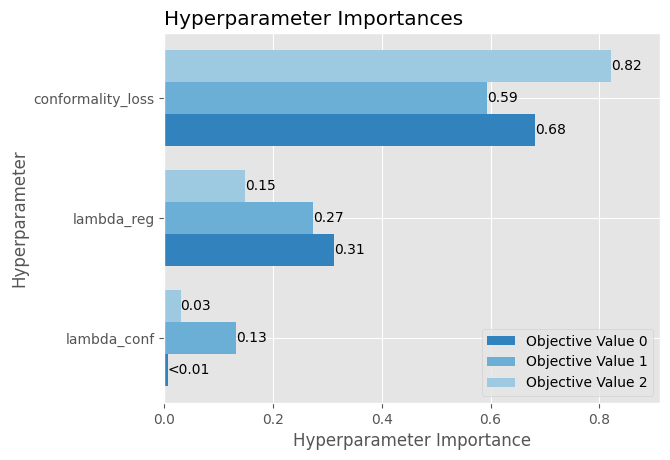

In [4]:
vis.matplotlib.plot_param_importances(study)
# hps.axis("equal")

In [9]:
# use Plotly-based optuna visualization for interactive 3D Pareto front
pareto = vis.plot_pareto_front(
    study,
    include_dominated_trials=True,
    target_names=["Reconstruction Loss", "Conformality Loss", "Regularization Loss"]
)

# adjust layout and 3D axis titles
pareto.update_layout(
    width=700,
    height=600,
    scene=dict(
        xaxis_title="Reconstruction Loss",
        yaxis_title="Conformality Loss",
        zaxis_title="Regularization Loss"
    )
)

pareto.show()

# pareto.set_xscale("log")
# pareto.set_yscale("log")

# pareto.set_xscale("log")
# pareto.set_yscale("log")

/tmp/ipykernel_3103161/2849105798.py:2: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



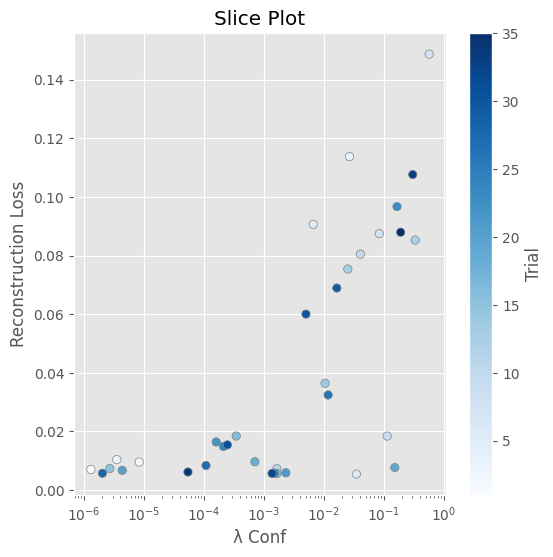

In [10]:
# plot objective 0 (first objective) across hyperparameters
slice0 = vis.matplotlib.plot_slice(study, params=["lambda_conf"], target=lambda t: t.values[0], target_name="Reconstruction Loss")
slice0.figure.set_size_inches(6, 6)
slice0.set_xlabel("λ Conf")
plt.show()

/tmp/ipykernel_1438133/256512276.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



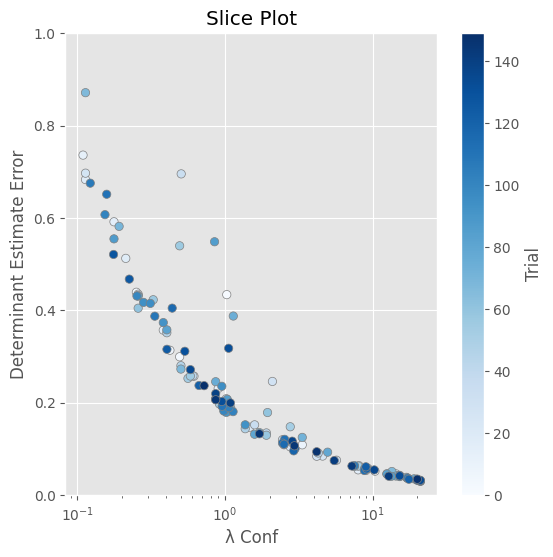

In [32]:
slice1 = vis.matplotlib.plot_slice(study, params=["lambda_conf"], target=lambda t: t.values[1], target_name="Determinant Estimate Error")
slice1.set_ylim(0.0, 1.0)
slice1.figure.set_size_inches(6, 6)
# set x label to Lambda Conf
slice1.set_xlabel("λ Conf")
plt.show()

In [18]:
fig = vis.plot_param_importances(study, evaluator=optuna.importance.MeanDecreaseImpurityImportanceEvaluator())  # plotly.graph_objs.Figure
labels = ["Determinant Estimate", "Reconstruction"]
colors = ['#1f77b4', '#ff7f0e']
for i, trace in enumerate(fig.data):
    trace.marker.color = colors[i % len(colors)]
    trace.name = labels[i]  # set legend label
    # set custom y-axis category labels with LaTeX
    fig.update_layout(
        yaxis=dict(
            categoryorder='array',
            categoryarray=["lambda_reg", "lambda_conf"],
            tickmode='array',
            tickvals=["lambda_reg", "lambda_conf"],
            ticktext=['λ_reg', "λ_conf"]  # LaTeX labels
        )
    )
fig.update_layout(width=650, height=450, legend=dict(y=0.01, x=0.6, traceorder='reversed'))
fig.show()

In [6]:
fig.data

(Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_reg (FloatDistribution):
                       0.014463848386535636<extra></extra>, lambda_conf
                       (FloatDistribution): 0.9855361516134644<extra></extra>],
     'marker': {'color': '#1f77b4'},
     'name': 'Determinant Estimate',
     'orientation': 'h',
     'text': [0.01, 0.99],
     'textposition': 'outside',
     'x': [0.014463848386535636, 0.9855361516134644],
     'y': [lambda_reg, lambda_conf]
 }),
 Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_reg (FloatDistribution):
                       0.051231404600740243<extra></extra>, lambda_conf
                       (FloatDistribution): 0.9487685953992598<extra></extra>],
     'marker': {'color': '#ff7f0e'},
     'name': 'Reconstruction',
     'orientation': 'h',
     'text': [0.05, 0.95],
     'textposition': 'outside',
     'x': [0.051231404600740243, 0.9487685953992598],
     'y': [lambda_reg, lambda_conf]
 }))

In [20]:
study3 = optuna.load_study(
    study_name='trace_optimal_params',
    storage='sqlite:///optuna_study.db'
)

In [91]:
study2 = optuna.create_study(directions=['minimize', 'minimize'], sampler=sampler, storage=storage, study_name="trace_best_trials", load_if_exists=True)

[I 2025-10-20 13:45:49,838] Using an existing study with name 'trace_best_trials' instead of creating a new one.


In [21]:
# Option A: set order by passing params in desired order
fig = vis.plot_param_importances(study3, evaluator=optuna.importance.MeanDecreaseImpurityImportanceEvaluator())  # plotly.graph_objs.Figure

# Option B (alternative): enforce a specific y-axis/category order after creating the figure
# If you prefer the other order, swap the list below.
fig.update_layout(yaxis=dict(categoryorder='array', categoryarray=["lambda_reg", "lambda_conf"]))
labels = ["Determinant Estimate", "Reconstruction"]
colors = ['#1f77b4', '#ff7f0e']
for i, trace in enumerate(fig.data):
    trace.marker.color = colors[i % len(colors)]
    trace.name = labels[i]  # set legend label


# set custom y-axis category labels with LaTeX
fig.update_layout(
    yaxis=dict(
        categoryorder='array',
        categoryarray=["lambda_reg", "lambda_conf"],
        tickmode='array',
        tickvals=["lambda_reg", "lambda_conf"],
        ticktext=['λ_reg', "λ_conf"]  # LaTeX labels
    )
)

# set pixel dimensions and legend
fig.update_layout(width=650, height=450, legend=dict(y=0.99, x=0.6, traceorder='reversed'))
fig.show()

In [23]:
study2 = optuna.load_study(
    study_name='iso_optimal_params',
    storage='sqlite:///optuna_study.db'
)

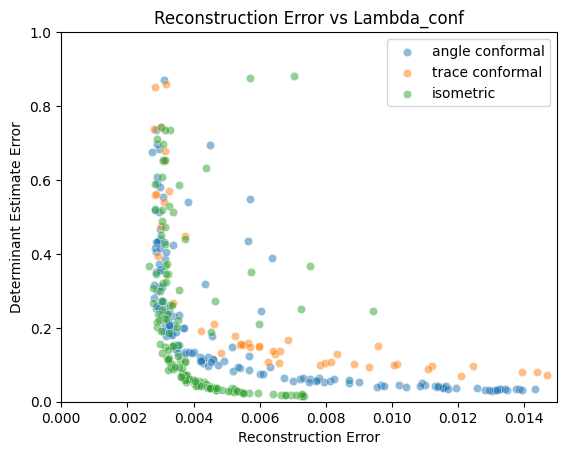

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()
df2 = study2.trials_dataframe()
df3 = study3.trials_dataframe()

# Now plot with filtered data
sns.scatterplot(data=df, x='values_0', y='values_1', label="angle conformal", alpha=0.5)
sns.scatterplot(data=df3, x='values_0', y='values_1', label="trace conformal", alpha=0.5)
sns.scatterplot(data=df2, x='values_0', y='values_1', label="isometric", alpha=0.5)
plt.title("Reconstruction Error vs Lambda_conf")
# plt.xscale('log')
plt.ylim(0, 1.0)
plt.xlim(0, 0.015)
plt.xlabel("Reconstruction Error")
plt.ylabel("Determinant Estimate Error")
plt.show()

In [98]:
fig.data

(Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_conf (FloatDistribution):
                       0.3660945832016772<extra></extra>, lambda_reg
                       (FloatDistribution): 0.6339054167983228<extra></extra>],
     'marker': {'color': '#1f77b4'},
     'name': 'Determinant Estimate',
     'orientation': 'h',
     'text': [0.37, 0.63],
     'textposition': 'outside',
     'x': [0.3660945832016772, 0.6339054167983228],
     'y': [lambda_conf, lambda_reg]
 }),
 Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_conf (FloatDistribution):
                       0.018151335991300182<extra></extra>, lambda_reg
                       (FloatDistribution): 0.9818486640086999<extra></extra>],
     'marker': {'color': '#ff7f0e'},
     'name': 'Reconstruction',
     'orientation': 'h',
     'text': [0.02, 0.98],
     'textposition': 'outside',
     'x': [0.018151335991300182, 0.9818486640086999],
     'y': [lambda_conf, lambda_reg]
 }))

In [36]:
# 3d plot of objective0 as a function of lambda_conf and lambda_reg
vis.plot_contour(study, params=["lambda_conf", "lambda_reg"], target=lambda t: t.values[0])

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [31]:
# 3d plot of objective0 as a function of lambda_conf and lambda_reg
vis.plot_contour(study, params=["lambda_conf", "lambda_reg"], target=lambda t: t.values[1])

In [42]:
# Filter study trials for specific parameter value
filtered_trials = [trial for trial in study.trials 
                  if trial.params.get('conformality_loss') == 'trace2']

# Create a new study with filtered trials
filtered_study = optuna.create_study(directions=['minimize', 'minimize'])
for trial in filtered_trials:
    filtered_study.add_trial(trial)

# Plot the filtered study
vis.plot_contour(filtered_study, params=["lambda_conf", "lambda_reg"], target=lambda t: t.values[1])

[I 2025-08-06 18:12:37,859] A new study created in memory with name: no-name-cb65c66b-6a30-4b83-b936-16c49bec19fd


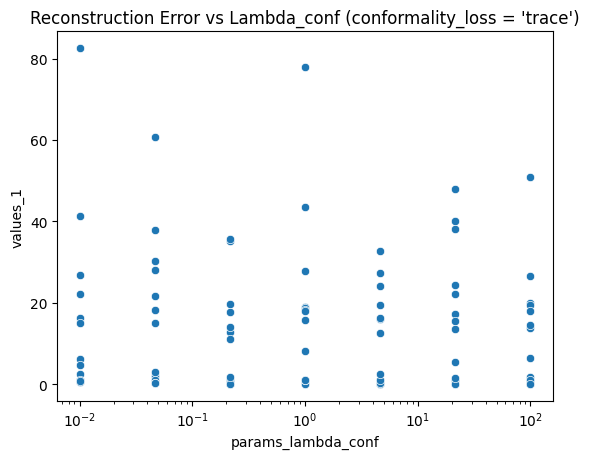

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()

# Filter by specific parameter value
df_filtered = df[df['params_conformality_loss'] == 'trace']  # Only 'trace' trials
# Or filter for multiple values
df_filtered = df[df['params_conformality_loss'].isin(['trace', 'trace2'])]

# Now plot with filtered data
sns.scatterplot(data=df_filtered, x='params_lambda_conf', y='values_1')
plt.title("Reconstruction Error vs Lambda_conf (conformality_loss = 'trace')")
plt.xscale('log')
plt.show()

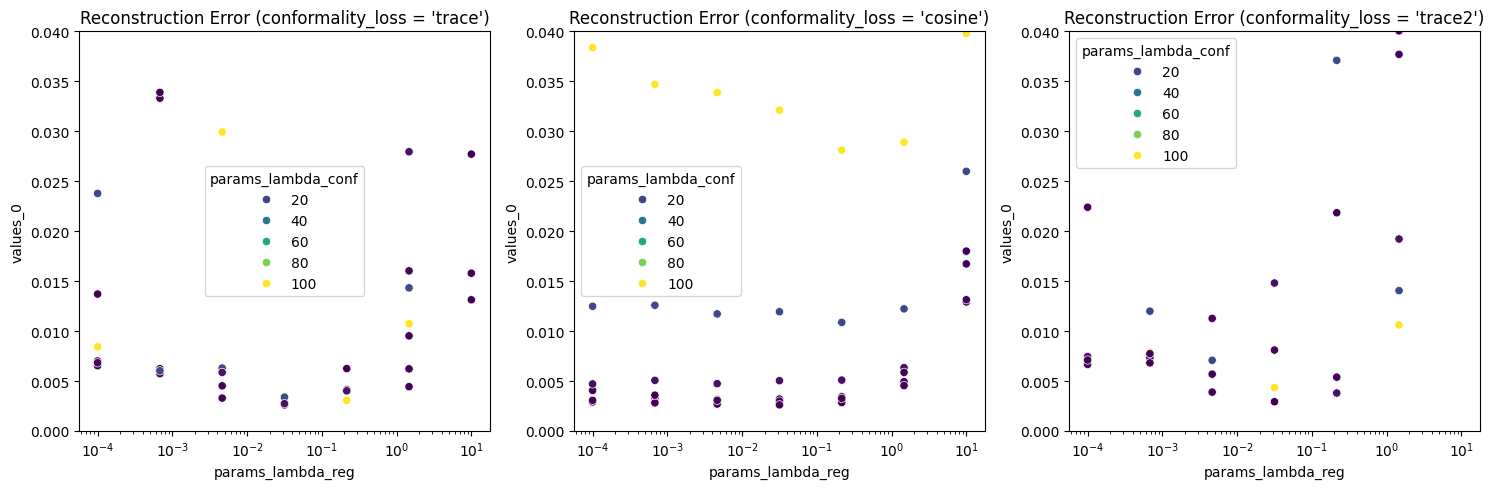

In [56]:
# Get unique values for the categorical parameter
conf_loss_types = df['params_conformality_loss'].unique()

fig, axes = plt.subplots(1, len(conf_loss_types), figsize=(15, 5))

for i, loss_type in enumerate(conf_loss_types):
    df_subset = df[df['params_conformality_loss'] == loss_type]
    
    sns.scatterplot(data=df_subset, x='params_lambda_reg', y='values_0', ax=axes[i], hue='params_lambda_conf', palette='viridis')
    axes[i].set_title(f"Reconstruction Error (conformality_loss = '{loss_type}')")
    axes[i].set_xscale('log')
    axes[i].set_ylim(0, 0.04)

plt.tight_layout()
plt.show()

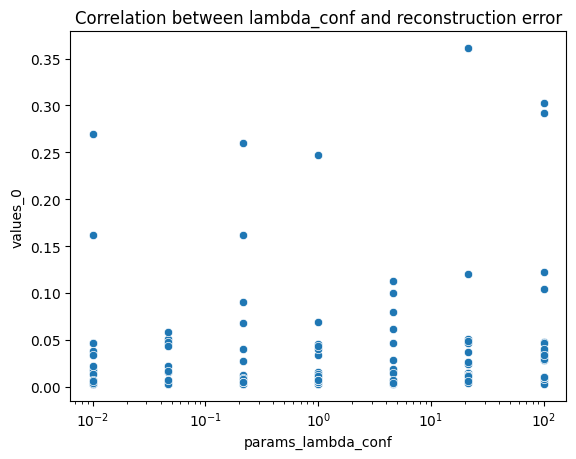

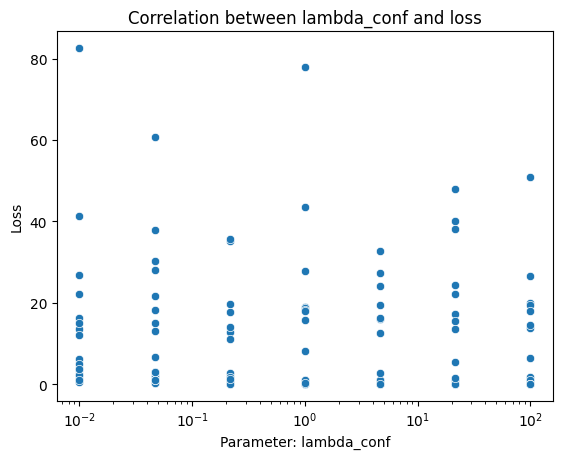

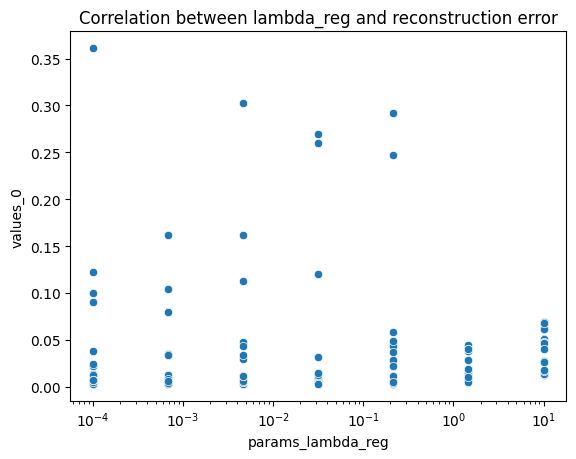

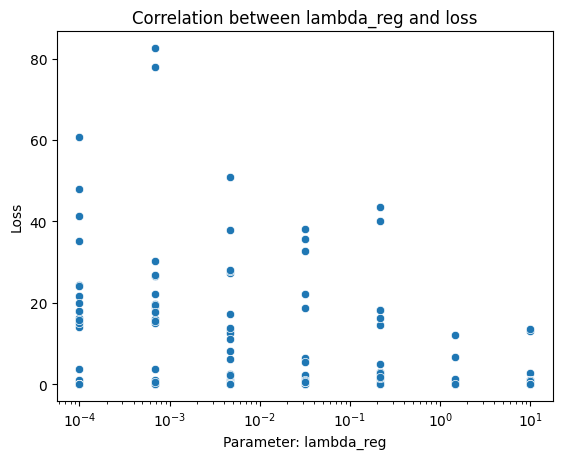

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()

# Optional: filter only completed trials
df = df[df['state'] == 'COMPLETE']

# Choose a parameter
param1 = 'lambda_conf'  # or 'lambda_reg'
param2 = 'lambda_reg'

# Plot param vs loss
sns.scatterplot(data=df, x=f'params_{param1}', y='values_0')  # Assuming first value is reconstruction error
plt.title(f"Correlation between {param1} and reconstruction error")
# plt.ylim(0, 0.03)
plt.xscale('log')
plt.show()
sns.scatterplot(data=df, x=f'params_{param1}', y='values_1')  # Assuming 'value' is the loss
plt.xlabel(f'Parameter: {param1}')
plt.ylabel('Loss')
plt.xscale('log')  # Use logarithmic scale for better visibility
# plt.ylim(-1, 0)  # Adjust y-axis limit if necessary
plt.title(f"Correlation between {param1} and loss")
plt.show()
sns.scatterplot(data=df, x=f'params_{param2}', y='values_0')  # Assuming 'value' is the loss
plt.title(f"Correlation between {param2} and reconstruction error")
plt.xscale('log')
plt.show()
sns.scatterplot(data=df, x=f'params_{param2}', y='values_1')  # Assuming 'value' is the loss
plt.xlabel(f'Parameter: {param2}')
plt.ylabel('Loss')
# plt.ylim(-1, 0)  # Adjust y-axis limit if necessary
plt.title(f"Correlation between {param2} and loss")
plt.xscale('log')
plt.show()

In [ ]:
conformality_loss cosine
lambda_conf 0.1 - 25
lambda_ref 0.00001 - 2

In [59]:
vis.plot_pareto_front(study, include_dominated_trials=True)

In [61]:
vis.plot_pareto_front(study, include_dominated_trials=False)

In [24]:
import optuna.visualization as vis
vis.plot_contour(study, params=[param1, param2], target=lambda t: t.values[0])  # Assuming first value is reconstruction error

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [13]:
print(study.trials_dataframe())

   number  values_0   values_1             datetime_start  \
0       0  0.131074  -0.195635 2025-07-28 17:43:49.210484   
1       1  0.077975  -0.437632 2025-07-28 17:43:55.598358   
2       2  0.118359  -0.008398 2025-07-28 17:44:01.260308   
3       3  0.067868  -0.062619 2025-07-28 17:44:06.906381   
4       4  0.132944  -0.123222 2025-07-28 17:44:12.574133   
5       5  0.032433  -0.916306 2025-07-28 17:44:18.240920   
6       6  0.149123  -0.382525 2025-07-28 17:44:23.903965   
7       7  0.121743  -0.962378 2025-07-28 17:44:29.568981   
8       8  0.054965 -10.185285 2025-07-28 17:44:35.251230   
9       9  0.103213  -0.011462 2025-07-28 17:44:40.906889   

           datetime_complete               duration  params_lambda_conf  \
0 2025-07-28 17:43:55.597779 0 days 00:00:06.387295            3.450764   
1 2025-07-28 17:44:01.259687 0 days 00:00:05.661329            4.271127   
2 2025-07-28 17:44:06.905917 0 days 00:00:05.645609            6.949206   
3 2025-07-28 17:44:12.573647